<a href="https://colab.research.google.com/github/thad75/TP_ENSEA_ELEVE/blob/main/3A/SIA/TP2/Generative_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
!tar xvzf /content/maps.tar.gz
!pip install pytorch-lightning


--2023-10-27 17:51:49--  https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz.1’

maps.tar.gz.1       100%[===================>] 238.65M  32.8MB/s    in 5.6s    

2023-10-27 17:51:55 (42.6 MB/s) - ‘maps.tar.gz.1’ saved [250242400/250242400]

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/tr

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(42)
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
import cv2 as cv
from google.colab.patches import cv2_imshow
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer

# Generating Images

In recent studies, Groundbreaking research are done using diffusion models to generate images. However, previously other models were used to perform that task. Image Generation has multiple application in Industries (NFT Creation, Virtual Try Outs, Deep Fake Generation..)

Goal of this lab :
* Hands on Generative Models
* Solidify your knowledge in Deep Learning
* Use someone else's code
* Reuse Pytorch Lightning
* Have an Insight of industrial application of AI

## Back to the Basics : AutoEncoders

As you might remember in your 2nd year labs, we used an AutoEncoder to recreate some input images. In this part, we will reconstruct data from the MNIST Dataset.


### Lightning DataModule

We will reuse the datamodule used in the first lab. So just run the following cell.

In [ ]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        self.data_dir = ''
        self.batch_size = 32

    def prepare_data(self):
        # This method is used to download beforehand the dataset if needed.
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage):
        # First stage is 'fit' (or None)
        if stage == "fit" or stage is None:
            # We create a validation split to watch the training.
            mnist_train_dataset = MNIST(self.data_dir, train=True, transform=self.transform)
            self.train_size = int(0.8 * len(mnist_train_dataset))
            self.valid_size = len(mnist_train_dataset) - self.train_size
            self.mnist_train, self.mnist_valid =  torch.utils.data.random_split(mnist_train_dataset, [self.train_size, self.valid_size])
        # Second stage is 'test'
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_valid, self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.mnist_test,self.batch_size, shuffle=True)

### Lightning Module

#### AutoEncoder : Creating and Using a Latent Space

<img src="https://miro.medium.com/max/600/1*nqzWupxC60iAH2dYrFT78Q.png">

Reminder : An AutoEncoder is composed of an Encoder and a Decoder. The Encoder creates a representation of the input datas, called latent space. The Decoder uses the latent space representation of the Input to reconstruct it.

We provide you with a code of an AutoEncoder class.
* **Using the given code, create an AutoEncoder composed of 3 stacks.**

In [ ]:
import torch.nn as nn
import torch
class ConvDown(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(ConvDown, self).__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.model = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.out_channels,
                                            kernel_size = 3,
                                            stride = 1,
                                            padding = 0,
                                            dilation = 1),
                                  nn.BatchNorm2d(self.out_channels),
                                  nn.Dropout2d(0.5),
                                  nn.LeakyReLU(0.2))
  def forward(self,x):
      return self.model(x)

class ConvUp(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(ConvUp, self).__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.model = nn.Sequential(nn.ConvTranspose2d(in_channels = self.in_channels,
                                      out_channels = self.out_channels,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 0,
                                      dilation = 1),
                    nn.LeakyReLU(0.2))
  def forward(self,x):
      return self.model(x)

class Encoder(nn.Module):
  def __init__(self, in_channels, number_of_stack):
    super(Encoder, self).__init__()
    self.in_channels = in_channels
    self.number_of_stack = number_of_stack
    channels = [in_channels]+ [2**i for i in range(3,10)]
    self.encoder = nn.ModuleList([ConvDown(channels[i], channels[i+1]) for i in range(number_of_stack)])

  def forward(self, x):
    for i, layer in enumerate(self.encoder):
      x = layer(x)
    return x

class Decoder(nn.Module):
  def __init__(self, out_channels,number_of_stack ):
    super(Decoder, self).__init__()
    channels = [out_channels]+ [2**i for i in range(3,10)]
    self.decoder = nn.ModuleList([ConvUp(channels[i+1], channels[i]) for i in range(number_of_stack)])[::-1]

  def forward(self, x):
    for i, layer in enumerate(self.decoder):
      x = layer(x)
    return x

############################################## TODO ##############################################
class AutoEncoder(nn.Module):
  def __init__(self, in_channels, number_of_stack):
    super().__init__()
    self.in_channels = in_channels
    self.number_of_stack = number_of_stack
    self.encoder = Encoder(self.in_channels, number_of_stack)
    self.decoder = Decoder(self.in_channels, number_of_stack)

  def forward(self, x):
    # TODO : Define your forward
    latent_representation = self.encoder(x)
    reconstructed_image = self.decoder(latent_representation)
    return reconstructed_image

# TODO : Create a model composed of 3 stacks
model = AutoEncoder(3,3)

print(model)

AutoEncoder(
  (encoder): Encoder(
    (encoder): ModuleList(
      (0): ConvDown(
        (model): Sequential(
          (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Dropout2d(p=0.5, inplace=False)
          (3): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ConvDown(
        (model): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Dropout2d(p=0.5, inplace=False)
          (3): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ConvDown(
        (model): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Dropout2d(p=0.5, inplace=False)
          (3): LeakyReLU(negative_slope=0.2)




*   Create your Lightning Module



In [ ]:
class AutoEncoderPL(pl.LightningModule):
    def __init__(self, in_channels, number_of_stack):
        super().__init__()
        self.save_hyperparameters()
        # TODO : Define your model here.
        self.model = AutoEncoder(in_channels, number_of_stack)

    def forward(self,x):
        # TODO : Send the input through your model
        return self.model(x)

    def configure_optimizers(self):
        # Choose your optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        # Define your Training Step
        # This method is pretty much similar to what your did in the first lab to train your model.
        x,y = train_batch
        x_reconstructed = self(x)
        loss = torch.nn.functional.mse_loss(x_reconstructed, x)
        # Don't remove the next line, you will understand why later
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        # Define your Validation Step
        # What is the difference between the Training and the Validation Step ?
        x,y = val_batch
        x_reconstructed = self(x)
        loss = torch.nn.functional.mse_loss(x_reconstructed, x)
        self.log('val_loss', loss)

    def test_step(self, test_batch, batch_idx):
        # Define your Test Step
        # What is the difference between the Training, Validation and Test Step ?
        x,y = test_batch
        x_reconstructed = self(x)
        loss = torch.nn.functional.mse_loss(x_reconstructed, x)
        # Don't remove the next line, you will understand why later
        self.log('test_loss', loss)

    # TODO : Do we have to add some functions (test_epoch_start, test_epoch_end..) to compute a reconstruction metric ?

The commented parts about additional functions "test_epoch_start" and "test_epoch_end" are not required for a basic autoencoder. We can implement those functions if we need to compute more complex metrics or operations during the testing phase.

#### Training

##### Setting TensorBoard up

In [ ]:
!kill 27717

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir "/content/lightning_logs/version_9" --port 6003 # You might have to change the name of the folder, just look what folder were created on your Colab environment

<IPython.core.display.Javascript object>

##### Launch the Training

In [ ]:
# TODO :
model = AutoEncoderPL(in_channels=1, number_of_stack=3)
dm = MNISTDataModule(batch_size=32)
max_epochs = 10
trainer = pl.Trainer(accelerator="gpu",max_epochs=max_epochs)
trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type        | Params
--------------------------------------
0 | model | AutoEncoder | 11.9 K
--------------------------------------
11.9 K    Trainable params
0         Non-trainable params
11.9 K    Total params
0.047     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


#### Testing

Test some images from the testing dataset to verify that your model works.

In [ ]:
# TODO : Load your test dataloader from the datamodule
dm.setup(stage= "test")
test_dataloader = dm.test_dataloader()
#trainer.test(model, dm)
# TODO : Compute your average reconstruction on the test set.

model.eval()  # Set the model to evaluation mode
total_loss = 0.0
num_samples = 0

with torch.no_grad():
    for batch in test_dataloader:
        x, _ = batch
        x_reconstructed = model(x)
        loss = torch.nn.functional.mse_loss(x_reconstructed, x, reduction='sum')
        total_loss += loss
        num_samples += x.size(0)

average_reconstruction_loss = total_loss / num_samples
print("Average Reconstruction Loss on Test Set:", average_reconstruction_loss.item())

RuntimeError: ignored

In [ ]:
# TODO : Plot some reconstructed images. Are they correct ?


# Define the number of images to plot
num_images_to_plot = 5

with torch.no_grad():
    for batch in test_dataloader:
        x, _ = batch
        x_reconstructed = model(x)
        x = x.cpu().numpy()
        x_reconstructed = x_reconstructed.cpu().numpy()

        for i in range(num_images_to_plot):
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(x[i][0], cmap='gray')
            plt.title("Original")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(x_reconstructed[i][0], cmap='gray')
            plt.title("Reconstructed")
            plt.axis('off')

            plt.show()
        break  # Plot only one batch of images

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TypeError: ignored

### Going Further on AutoEncoders (Optional)

If you have some time, create other AutoEncoder with differnet latent sizes and train it.
* **What is the impact of the latent space toward the images reconstructions ?**

## Industrial Application of GAN : Creating Google Maps Calque from Google Map Satellite view

Working on basic datasets is cool but as you are engineers to be, let's take it to industrial level. Given an image of a Google Map Satellite view, we want the model to predict a Calque view from it. This task is an Image translation task.

For example, using the image on the left, we want the model to predict the image on the right.
<img src="https://eu42.github.io/images/gcgan/aerial_image_map_example.png" height = 200>



### Lightning DataModule



#### Dataset

First, we need to write the Dataset. As usual, a custom Dataset class must implement three functions:
* __init__
* __len__
* __getitem__

Each image's shape is 1200x600x3. The satellite and the calque has the same size and are exactly half of the image

As the dataset doesn't have a proper test dataset, we will use the validation dataset as the test set. We will further create a validation dataset by taking a portion of the train dataset

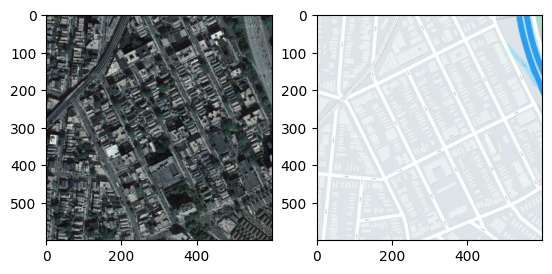

In [ ]:
class GoogleDataset(Dataset):

  def __init__(self, path, transform = None):
    self.path = path
    self.images = [path + i for i in os.listdir(path)]
    self.transform = transform

  def __getitem__(self,idx):
    image = self.images[idx]
    full_image = cv2.imread(image)
    h,w,c = full_image.shape
    # TODO : Retrieve the correct parts of the image.
    satellite = full_image[:, :w // 2, :]
    calque = full_image[:, w // 2:, :]
    if self.transform :
      satellite = self.transform(satellite)
      calque = self.transform(calque)
    return {'satellite':satellite,
            'calque':calque}

  def __len__(self):
    return len(self.images)

data = GoogleDataset("/content/maps/train/")
plt.subplot(121)
plt.imshow(data[2]["satellite"])
plt.subplot(122)
plt.imshow(data[2]["calque"])

#### Lightning DataModule

Now, let's prepare our DataModule.

In [ ]:
class GoogleMapDataModule(pl.LightningDataModule):

    def __init__(self, batch_size):
        super().__init__()
        # TODO : In your Transformation, transform to Tensor and resize images to 128x128
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((128, 128)),  # Resize images to 128x128
            ])
        self.batch_size = batch_size

        # we are hardcoding the path are they won't change
        self.train_path = '/content/maps/train/'
        self.test_path = '/content/maps/val/'

    def prepare_data(self):
        # TODO : load the train and test dataset
        GoogleDataset(self.train_path, self.transform)
        GoogleDataset(self.test_path, self.transform)


    def setup(self, stage):

        #First stage is 'fit' (or None)
        if stage == "fit" or stage is None:
            # We create a validation split to watch the training.
            google_train = GoogleDataset(self.train_path, self.transform)
            train_size = int(0.7 * len(google_train ))
            test_size = len(google_train ) - train_size
            self.google_train, self.google_valid =  torch.utils.data.random_split(google_train , [train_size, test_size])
        #Second stage is 'test'
        if stage == "test" or stage is None:
            self.google_test = GoogleDataset(self.test_path, self.transform)

    def train_dataloader(self):
        # TODO : Now create your Training DataLoader
        return DataLoader(self.google_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        # TODO : Now create your Validation DataLoader
        return DataLoader(self.google_valid, batch_size=self.batch_size)

    def test_dataloader(self):
        # TODO : Now create your Testing DataLoader
        return DataLoader(self.google_test, batch_size=self.batch_size)

### Lightning Module

* **Can we use an AutoEncoder to perform this task ?**


Yes, we can use an autoencoder to perform the task of generating a "Calque" view from a Google Maps satellite view. Autoencoders are a type of neural network architecture that can be used for various tasks, including image-to-image translation tasks.


Let's use a much complex model. Generative Adversarial Networks.

#### Pix2Pix : cGAN

Instead of using a simple GAN, we will use a  conditional GAN (cGAN).

<img src='https://www.researchgate.net/profile/Gerasimos-Spanakis/publication/330474693/figure/fig1/AS:956606955139072@1605084279074/GAN-conditional-GAN-CGAN-and-auxiliary-classifier-GAN-ACGAN-architectures-where-x_Q320.jpg'>

 On the contrary of a normal GAN, cGAN has a condition that will help us CONTROL how the GAN should generate images. The generator will take some "inspiration" from the Condition. For example, if you want to generate digits from the MNIST Dataset, you can add a condition to force the GAN to create a specific Digit. In the MNIST case, the condition would be the class label.

Further details are in the following paper : https://arxiv.org/pdf/1411.1784.pdf



##### The Generator : Generating Images

In general, the Generator is here to generate Data from Noise. For example if we train a GAN on MNIST dataset, the generator will create digits using the noise we give it as input. In this lab, we are dealing with cGANs, so we need a Condition to condition our GAN.
* **What could be the condition in this task ?**

To answer that :
* **What are we trying to do ?**
* **What should the Generator do ? Should it recreate something specific ?**



**1 What Are We Trying to Do?**

We are trying to generate map overlays (calques) based on satellite images. This means the generator should take a satellite image as input and produce a corresponding map overlay.


**2 What Should the Generator Do? Should It Recreate Something Specific?**

Yes, the generator should recreate a specific map overlay that is consistent with the provided satellite image. The condition should guide the generator in creating a map overlay that aligns with the features, structures, or information present in the satellite image.



Let's use an AutoEncoder to perform the image translation.
* **Using previous classes, initialize your Generator using a 3 stack AutoEncoder.**

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels, latent_size, out_channels):
        super(Generator, self).__init__()
        self.autoencoder = AutoEncoder(in_channels, 3)

    def forward(self, x):
        # Forward pass through the AutoEncoder
        latent_representation = self.autoencoder(x)
        return latent_representation


##### The Discriminator : Forcing the Generator to predict better

The generator is able to create Images from Inputs, but we want the best quality possible. We need a model that would indicate to the Generator whether the generated Image are correct or not : the Discriminator.

The Discriminator is here to force the Generator to create better and better images. While the Generator creates bad quality generated image, the Discriminator will give a feedback.

<img src="https://i.imgflip.com/6y0kqe.jpg">

* **What could be the worst case scenario with the Generator and the Discriminator ?**


**1 Worst-Case Generator:** The Generator fails to produce any meaningful or relevant images. It may generate completely random or nonsensical images that have no resemblance to the target domain (in this case, map overlays). The Generator is essentially ineffective and cannot generate useful outputs.

**2 Worst-Case Discriminator:** The Discriminator is unable to distinguish between real and generated images. It might classify all images, whether real or fake, as real. This means the Discriminator is providing no useful feedback to the Generator, and the Generator is not learning or improving its image generation.

We provide you the code of a Discriminator that "works well".

In [ ]:
class DiscriConv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.model = nn.Sequential(nn.Conv2d(in_channels = in_channels,
                                  out_channels = out_channels,
                                  kernel_size = kernel_size,
                                  stride = 2,
                                  padding = 1),
                                  nn.BatchNorm2d(out_channels),
                                  nn.LeakyReLU(0.2, inplace=True))

  def forward(self,x):
      return self.model(x)

class Discriminator(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(DiscriConv(in_channels, 32,3),
                              DiscriConv(32, 64,4),
                              DiscriConv(64, 128,4),
                              # 128x4x4
                              nn.Conv2d(in_channels = 128,
                                        out_channels = out_channels,
                                        kernel_size = 3,
                                        bias=False))

  def forward(self, input):
    return self.main(input)

NameError: ignored

##### The Loss : Adversarial Battle

<img src="https://miro.medium.com/max/1400/1*d96q6bCKbmZT9Ls7f3X6xg.jpeg">

This formula is the basic loss of the cGAN model. There are two terms, each optimizing specific.
Beautiful formula's no ? Let's understand them like humans.
* What is x, y, z in our Case ?

x: Real satellite images (input) from the dataset.

y: Real map overlay images (target) corresponding to the real satellite images.

z: Random noise or latent representation used by the Generator.

If we look at the formulas, there are two losses :
* What kind of losses are they ? Cross Entropies, Distance Losses ?
* Which term is the Discriminator loss ? Generator loss ?

**.**LcGAN(G, D) is a cross-entropy loss used for adversarial training, while Ll1(G) and Ll2(G) are distance losses used to measure the pixel-wise differences between real and generated images. These different loss components are combined to train the conditional GAN model effectively.


**.**The Discriminator loss is the first term in LcGAN(G, D), which is Ex,y[logD(x, y)]. It represents how well the Discriminator can classify real map overlays correctly.

**.** The Generator loss is the second term in LcGAN(G, D), which is Ex,z[log(1-D(x, G(x, z)))]. It represents the Generator's objective to produce fake map overlays that can fool the Discriminator into classifying them as real.



The entire model will converge when the Generator provides the best fakes possible that the Discriminator won't be able to differentiate from the real images.

In [ ]:
class GANLoss(nn.Module):
      def __init__(self, real_label=1, fake_label=0):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()
        # Initialization a binary label, if real label 1, if fake label 0
        self.real_label = real_label
        self.fake_label = fake_label

      def get_labels(self, predictions, real_or_not):
          # TODO : If we have a real data as input, we want its target label to be self.real_label. If we have fake data as input, we want its target lable to be self.fake_label
          # Fill in the ...
          labels = self.real_label if real_or_not else self.fake_label
          return torch.tensor(labels).expand_as(predictions).to(predictions.device)

      def forward(self, predictions, real_or_not):
          # TODO : Return the Loss between the models prediction and the labels
          labels = self.get_labels(predictions, real_or_not)
          loss = self.loss(predictions, labels.float())
          return loss

##### The Final Module

Let's encompass everything under our Lightning Module. However, there are many steps to follow. In order to understand the code, read the commented parts.

In [ ]:
class GAN(pl.LightningModule):
  def __init__(self ):
    super().__init__()
    # TODO : Initalize your Generator and Discriminator
    self.generator = Generator(in_channels = 3,
                               latent_size = 256,
                               out_channels = 3)
    self.discriminator = Discriminator(in_channels = 2*3,
                                       out_channels = 1)
    # Define your optimizers
    self.optimizer_generator = torch.optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.005, 0.999))
    self.optimizer_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.005, 0.999))

  def forward(self,satellite):
    img_fake = self.generator(satellite)
    return img_fake

  def configure_optimizers(self):
      # Return the optimizers
      return [self.optimizer_generator, self.optimizer_discriminator]

  def training_step(self, train_batch, batch_idx):#, optimizer):
    # TODO:  Follow the steps
    satellite, calque = train_batch['satellite'], train_batch['calque']
    # Disclaimer : You might have to put some self. ...
    criterion = GANLoss()
    criterionL1 = nn.L1Loss() # We add the L1 Loss for better correspondance between the colors


    # Discriminator Training Part
    fake_calque = self.generator(satellite)
    fake_data = torch.cat([satellite, fake_calque], dim=1)
    fake_prediction = self.discriminator(fake_data)
    loss_fake = criterion(fake_prediction, real_or_not=False)
    real_data = torch.cat([satellite, calque], dim=1)
    real_prediction = self.discriminator(real_data)
    loss_real = criterion(real_prediction, real_or_not=True)
    loss = (loss_real + loss_fake) / 2
    self.log('discriminator loss', loss)

    # Manually optimize the discriminator
    self.optimizer_discriminator.zero_grad()
    self.manual_backward(loss)
    #loss.backward()
    self.optimizer_discriminator.step()

    if batch_idx % 1 == 0:
      # Generator Training Part
      fake_calque = self.generator(satellite)
      fake_data = torch.cat([satellite, fake_calque], dim=1)
      fake_prediction = self.discriminator(fake_data)
      loss_g = criterion(fake_prediction, real_or_not=True)
      loss_l1 = criterionL1(fake_calque, calque) * 100
      self.log('generator loss', loss_g)

      # Manually optimize the generator
      self.optimizer_generator.zero_grad()
      self.manual_backward(loss_g, retain_graph=True)
      self.manual_backward(loss_l1, retain_graph=True)
      (loss_g + loss_l1).backward()
      self.optimizer_generator.step()

  def validation_step(self, val_batch, batch_idx):

    satellite, calque = val_batch['satellite'], val_batch['calque']
    criterion = GANLoss()
    criterionL1 = nn.L1Loss()
    # TODO : Send the Satellite Image through the Generator
    fake_calque = self.generator(satellite)
    # TODO : Compute the Loss between the fake calque and the real calque
    loss_calque = criterionL1(fake_calque, calque)
    # TODO : Send the fake calque, the satellite to the Discriminator, and compute the loss
    fake_data = torch.cat([satellite, fake_calque], dim=1)
    fake_prediction = self.discriminator(fake_data)
    # TODO : Send the real calque, the satellite to the Discriminator,and compute the loss
    real_data = torch.cat([satellite, calque], dim=1)
    real_prediction = self.discriminator(real_data)
    loss_real = criterion(real_prediction, real_or_not=True)
    loss_fake = criterion(fake_prediction, real_or_not=False)
    # TODO : Don't forget to log the losses
    self.log('val_loss_real', loss_real)
    self.log('val_loss_fake', loss_fake)
    self.log('val_loss_calque', loss_calque)


  def test_step(self, test_batch, batch_idx):

    satellite, calque = test_batch['satellite'], test_batch['calque']
    criterion = GANLoss()
    criterionL1 = nn.L1Loss()
    # TODO : Send the Satellite Image through the Generator
    fake_calque = self.generator(satellite)
    # TODO : Compute the Loss between the fake calque and the real calque
    loss_calque = criterionL1(fake_calque, calque)
    # TODO : Send the fake calque, the satellite to the Discriminator, and compute the loss
    fake_data = torch.cat([satellite, fake_calque], dim=1)
    fake_prediction = self.discriminator(fake_data)
    # TODO : Send the real calque, the satellite to the Discriminator,and compute the loss
    real_data = torch.cat([calque, satellite], dim=1)
    real_prediction = self.discriminator(real_data)
    # TODO : Don't forget to log the losses
    loss_real = criterion(real_prediction, real_or_not=True)
    loss_fake = criterion(fake_prediction, real_or_not=False)
    self.log('test_loss_real', loss_real)
    self.log('test_loss_fake', loss_fake)
    self.log('test_loss_calque', loss_calque)

### Training

Train your model. We suggest you to train the model at least 10 epochs to see 'results'


In [ ]:
datamodule = GoogleMapDataModule(batch_size=32)
model = GAN()
model.automatic_optimization = False
trainer = pl.Trainer(accelerator="gpu", max_epochs=10)
trainer.fit(model, datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 12.1 K
1 | discriminator | Discriminator | 167 K 
------------------------------------------------
179 K     Trainable params
0         Non-trainable params
179 K     Total params
0.718     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### Testing

Test your model on few images of the test dataset. You can further try the model by cropping Satellite views from Google Maps

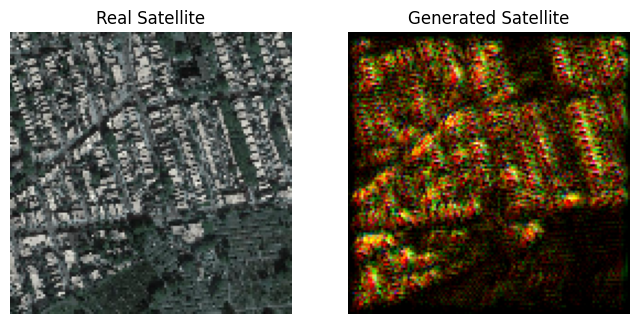

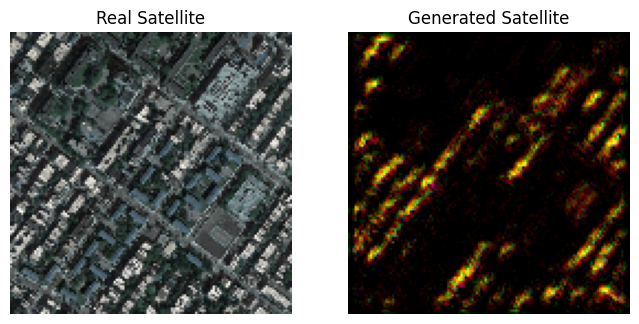

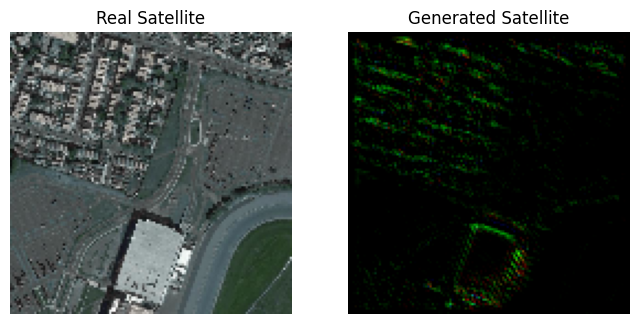

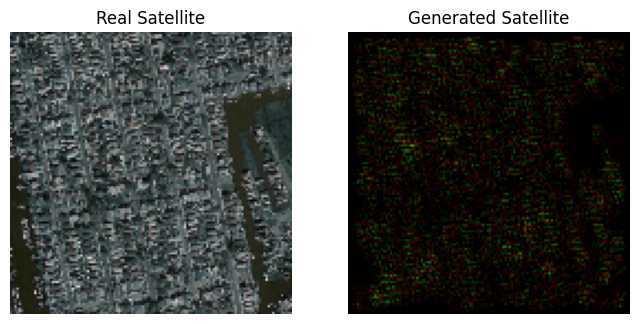

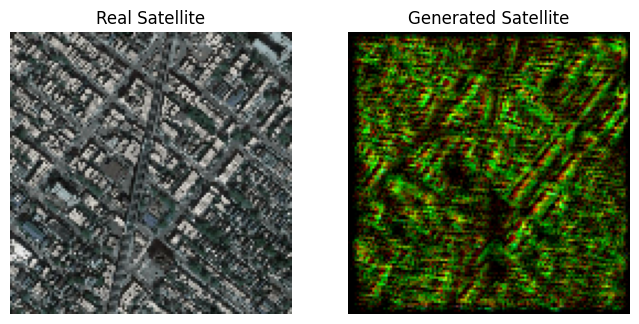

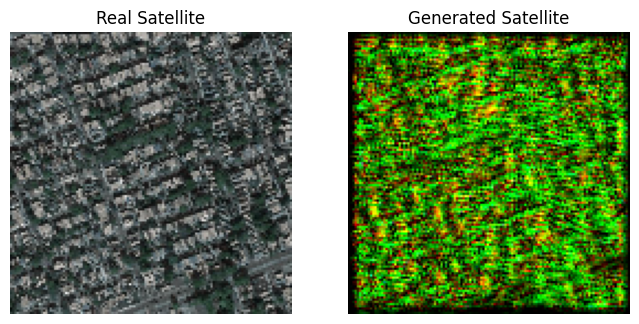

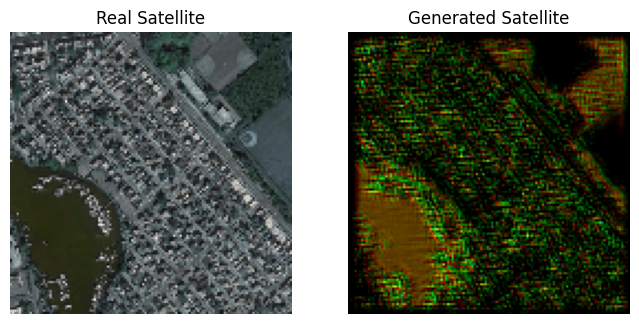

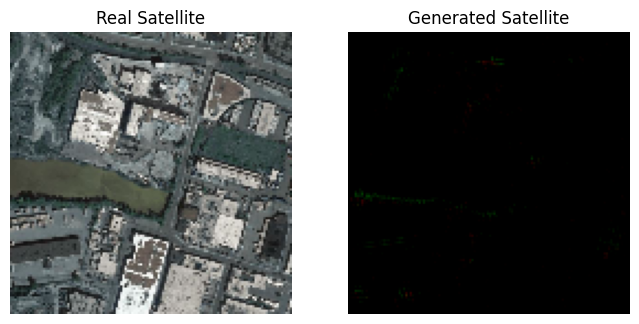

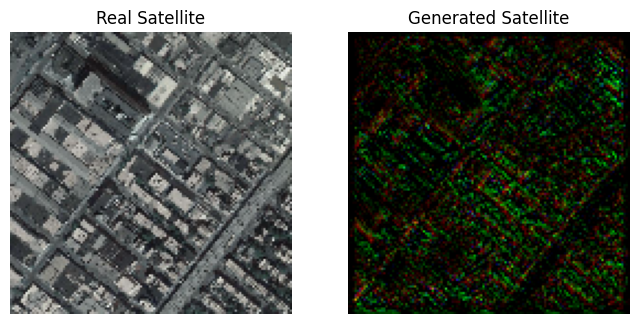

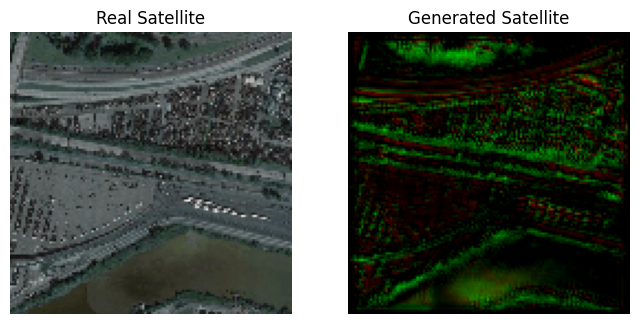

In [ ]:
# Define batch size and other hyperparameters
batch_size = 32

# Instantiate the data module
datamodule = GoogleMapDataModule(batch_size)

# Create an instance of your GAN model
model = GAN()

# Load the trained weights (if available)
# model.load_state_dict(torch.load("your_model_weights.pth"))

# Set the model to evaluation mode
#model.eval()

datamodule.setup(stage="test")

# Create a data loader for the test dataset
test_dataloader = datamodule.test_dataloader()

# Initialize a counter for the number of images displayed
displayed_images = 0

# Iterate through the test dataset and generate fake images
for batch in test_dataloader:
    # Get the real satellite images from the test batch
    real_satellite_images = batch['satellite']

    # Generate fake images using the generator
    with torch.no_grad():
        fake_satellite_images = model.generator(real_satellite_images)

    # Visualize and compare the real and fake images (you can use Matplotlib or another library)
    # Here's a simple example using Matplotlib:
    import matplotlib.pyplot as plt

    for i in range(batch_size):
        if displayed_images < 10:
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.title("Real Satellite")
            plt.imshow(real_satellite_images[i].permute(1, 2, 0))
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Generated Satellite")
            plt.imshow(fake_satellite_images[i].permute(1, 2, 0))
            plt.axis('off')

            plt.show()
            displayed_images += 1
        else:
            break

    if displayed_images >= 10:
        break  # Stop iterating once 10 images have been displayed
